# Notebook for the development of the model to power the face detection

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import torch
from PIL import Image
from torchvision.datasets import WIDERFace
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Resize
from torchvision.models.detection.faster_rcnn import fasterrcnn_mobilenet_v3_large_320_fpn, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights, FastRCNNPredictor
from collections import defaultdict
import os
import pathlib
import random
from typing import Tuple, List

### Constants

In [3]:
ROOT = "/content/" # Change to your root directory

### Download Data

In [4]:
WIDERFace(root="", download=True)

Downloading...
From (original): https://drive.google.com/uc?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M
From (redirected): https://drive.usercontent.google.com/download?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M&confirm=t&uuid=8034f38f-e793-4df2-a8f4-5bb453aaf2fd
To: /content/widerface/WIDER_train.zip
100%|██████████| 1.47G/1.47G [00:23<00:00, 62.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q
From (redirected): https://drive.usercontent.google.com/download?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q&confirm=t&uuid=cff440a1-2b73-49cb-9b07-7a9a29282767
To: /content/widerface/WIDER_val.zip
100%|██████████| 363M/363M [00:06<00:00, 58.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T
From (redirected): https://drive.usercontent.google.com/download?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T&confirm=t&uuid=129316a7-4c21-437b-a2de-9d12161073d8
To: /content/widerface/WIDER_test.zip
100%|██████████| 1.84G/1.84G 

100%|██████████| 3591642/3591642 [00:00<00:00, 7108113.61it/s]


Extracting widerface/wider_face_split.zip to widerface


Dataset WIDERFace
    Number of datapoints: 12880
    Root location: widerface
    Split: train

## Data Exploration

### Build dictionary with image name and folder as key and a list with the number of faces and the coordinates of the bounding boxes as value

In [5]:
# Make list from ground truth .txt file
ground_truth_file_list = []
with open(ROOT + "widerface/wider_face_split/wider_face_train_bbx_gt.txt") as file:
  for line in file:
    ground_truth_file_list.append(line.strip())

In [6]:
images_ground_truth = {}
index = 0
while index < len(ground_truth_file_list):
  if len(ground_truth_file_list[index].split(".")) == 2:
    image_name = ground_truth_file_list[index].strip()
    index += 1
    num_faces = int(ground_truth_file_list[index].strip())
    ground_truth = [num_faces]
    for _ in range(num_faces):
      index += 1
      ground_truth.append(list(map(lambda x: int(x), ground_truth_file_list[index].split(" ")))[:4]) # only num_faces / x, y, width, height
    images_ground_truth[image_name] = ground_truth
  index += 1

### Visualize 4 random example images with bounding boxes

In [7]:
def plot_image(axs, x, y, image):
  ground_truth = images_ground_truth[image]
  axs[x, y].imshow(mpimg.imread(ROOT + "widerface/WIDER_train/images/" + image))
  for rect in ground_truth[1:]:
    rect_x, rect_y, width, height = rect
    rect_obj = patches.Rectangle((rect_x, rect_y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    axs[x, y].add_patch(rect_obj)
  image_name = image.split("/")[1].split(".")[0]
  axs[x, y].set_title(image_name)

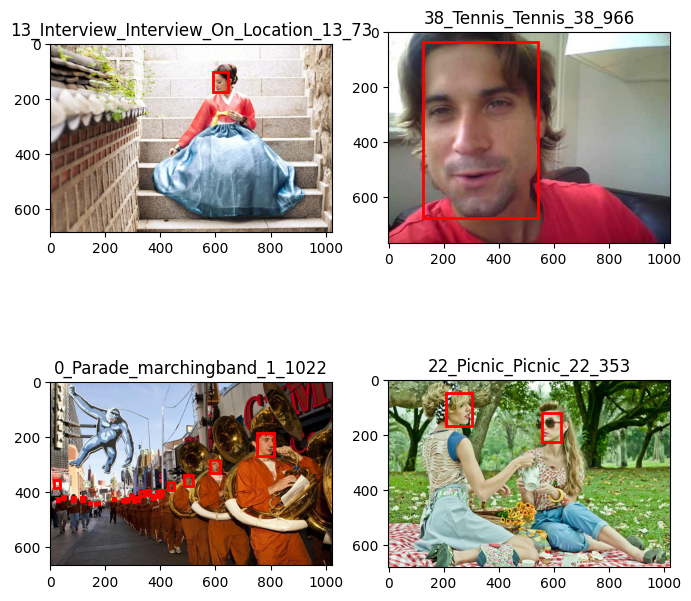

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

images = random.sample(list(images_ground_truth.keys()), 4)
# Plot first image
plot_image(axs, 0, 0, images[0])
# Plot second image
plot_image(axs, 0, 1, images[1])
# Plot third image
plot_image(axs, 1, 0, images[2])
# Plot fourth image
plot_image(axs, 1, 1, images[3])

### Explore Distribution over number of faces
-> Use log scale to better visualize extreme values

In [9]:
dist_num_faces = defaultdict(int)
with open(ROOT + "widerface/wider_face_split/wider_face_train_bbx_gt.txt") as file:
  for line in file:
    if len(line.split(" ")) == 1 and len(line.split(".")) == 1:
      dist_num_faces[int(line)] += 1
print(f"There are {dist_num_faces[0]} images with zero faces.")

There are 4 images with zero faces.


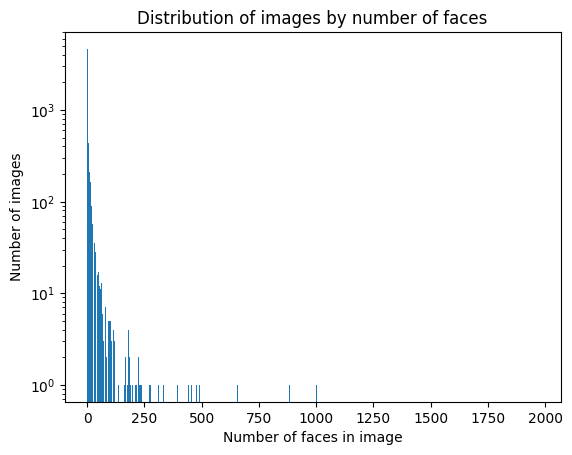

In [10]:
num_faces = list(dist_num_faces.keys())
frequency = list(dist_num_faces.values())

plt.bar(num_faces, frequency, log=True)
plt.xlabel('Number of faces in image')
plt.ylabel('Number of images')
plt.title('Distribution of images by number of faces')

plt.show()

## Build Dataset class

In [11]:
class FaceImageDataset(Dataset):
  """Dataset class for the WIDERFACE dataset.

  Attributes:
    data_dir (str): path to the directory with image directories in it.
    transform: transformation to perform on images.
  """


  def __init__(self, data_dir: str, ground_truth_file: str, transform=None) -> None:
    """Constructs Dataset class.

    Attributes:
      data_dir (str): path to the directory with image directories in it.
      transform: transformation to perform on images.
    """
    # Paths to the images
    self.__paths = list(map(lambda path: str(path), pathlib.Path(data_dir).glob("*/*.jpg")))
    self.__ground_truth_file = ground_truth_file
    self.__transform = transform
    self.__label_data = self.__get_label_data()


  def __get_label_data(self) -> dict:
    """Return dictionary with number of faces and bounding boxes for all images.
    """
    label_file = self.__get_label_file()
    label_data = {}
    index = 0
    index_image = 0
    while index < len(label_file):
      if len(label_file[index].split(".")) == 2:
        image_name = label_file[index].strip()
        index += 1
        num_faces = int(label_file[index].strip())
        boxes = []
        image = self.__load_image(index_image)
        index_image += 1
        original_height, original_width = image.shape[1:]
        for _ in range(num_faces):
          index += 1
          # only num_faces / x, y, width, height
          box_data = list(map(lambda x: int(x), label_file[index].split(" ")))[:4]
          if box_data[2] > 0 and box_data[3] > 0:
            x_0 = box_data[0] / original_width * 320
            x_1 = (box_data[0] + box_data[2]) / original_width * 320
            y_0 = box_data[1] / original_height * 320
            y_1 = (box_data[1] + box_data[3]) / original_height * 320
            box = [min(x_0, x_1), min(y_0, y_1), max(x_0, x_1), max(y_0, y_1)]
            boxes.append(box)
          else:
            num_faces -= 1
        label = {"labels": torch.tensor([1 for _ in range(num_faces)], dtype=torch.int64), "boxes": torch.tensor(boxes)}
        label_data[image_name] = label
      index += 1
    return label_data


  def __get_label_file(self) -> List[str]:
    """Returns list containing the lines of the ground truth file.
    """
    label_file_list = []
    with open(self.__ground_truth_file) as file:
      for line in file:
        label_file_list.append(line.strip())
    return label_file_list


  def __len__(self) -> int:
    """Returns the number of images.
    """
    return len(self.__paths)


  def __get_label(self, index: int) -> List:
    """Returns list with number of faces and bounding boxes for image at position index.

    Attributes:
      index (int): index of the image to get label data for.
    """
    image_path = self.__paths[index]
    path_parts = image_path.split("/")
    image_name = path_parts[-2] + "/" + path_parts[-1]
    return self.__label_data[image_name]


  def __load_image(self, index: int) -> Image.Image:
    """Return Image in Tensor form.

    Attributes:
      index (int): index of the image to load.
    """
    image_path = self.__paths[index]
    image = Image.open(image_path)
    tensor_transform = ToTensor()
    tensor_image = tensor_transform(image)
    return tensor_image


  def __getitem__(self, index: int) -> Tuple[torch.Tensor, List]:
    """Returns (transformed) image and label data for given index.

    Attributes:
      index (int): index for the item to get.
    """
    image = self.__load_image(index)
    original_height, original_width = image.shape[1:]
    label = self.__get_label(index)
    if not self.__transform:
      raise ValueError("No transform specified!")
    image = self.__transform(image)
    item = {"image": image, "targets": label}
    if len(label["boxes"]) == 0:
      return None
    else:
      return item

## Create DataLoaders, Transforms, etc.

In [12]:
# auto transformation
weights = FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT
transform = Compose([
    Resize((320, 320)),
    weights.transforms()
    ])

In [14]:
train_data_dir = ROOT + "widerface/WIDER_train/images/"
train_gt_file = ROOT + "widerface/wider_face_split/wider_face_train_bbx_gt.txt"
train_dataset = FaceImageDataset(train_data_dir, train_gt_file, transform)

In [15]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    X = [item["image"] for item in batch]
    y = [item["targets"] for item in batch]
    return X, y
train_dataloader = DataLoader(train_dataset, 32, shuffle=True, collate_fn=collate_fn)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Create and train model

In [17]:
model = fasterrcnn_mobilenet_v3_large_320_fpn(weights=weights).to(device)
# Configure the model for only use case
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 143MB/s]


In [18]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [19]:
model.train()
model.to(device)
num_epochs = 5
for epoch in range(num_epochs):
  loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X = [x.to(device) for x in X]
    y = [{"labels": target["labels"].to(device), "boxes": target["boxes"].to(device)} for target in y]
    # forward pass
    loss_dict = model(X, y)
    losses = sum(loss for loss in loss_dict.values())
    loss += losses
    # Backpropagation
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
  print(f"Loss after epoch {epoch}: {round(float(loss)/len(train_dataloader), 3)}.")

Loss after epoch 0: 0.415.
Loss after epoch 1: 0.404.
Loss after epoch 2: 0.402.
Loss after epoch 3: 0.397.
Loss after epoch 4: 0.392.


In [20]:
torch.save(model, ROOT + "fasterrcnn_complete_model.pth")

## Model evaluation (work in progress)

In [21]:
val_data_dir = ROOT + "widerface/WIDER_val/images/"
val_gt_file = ROOT + "widerface/wider_face_split/wider_face_val_bbx_gt.txt"
val_dataset = FaceImageDataset(val_data_dir, val_gt_file, transform)

In [24]:
val_dataloader = DataLoader(val_dataset, 32, shuffle=True, collate_fn=collate_fn)

In [49]:
val_loss = 0
image_boxes = []
model.eval()
model.to(device)
count = 0
with torch.no_grad():
    for batch, (X, y) in enumerate(train_dataloader):
      if batch < 5:
        count += len(X)
        X = [x.to(device) for x in X]
        y = [{"labels": target["labels"].to(device), "boxes": target["boxes"].to(device)} for target in y]
        preds = model(X, y)
        for x, y, pred in zip(X, y, preds):
          image_boxes.append((x, pred["boxes"], y["boxes"], pred["scores"]))
      else:
        break
image_boxes[0]

(tensor([[[0.1125, 0.1787, 0.1904,  ..., 0.2347, 0.2310, 0.1484],
          [0.3547, 0.6658, 0.6791,  ..., 0.6187, 0.5849, 0.3155],
          [0.4229, 0.7949, 0.8048,  ..., 0.7231, 0.6860, 0.3833],
          ...,
          [0.2126, 0.3688, 0.3885,  ..., 0.3374, 0.2845, 0.1632],
          [0.1425, 0.2276, 0.2451,  ..., 0.2472, 0.2073, 0.1218],
          [0.0588, 0.0567, 0.0627,  ..., 0.0795, 0.0713, 0.0460]],
 
         [[0.1289, 0.1934, 0.1972,  ..., 0.1314, 0.1256, 0.0880],
          [0.3659, 0.6825, 0.6860,  ..., 0.4966, 0.4607, 0.2428],
          [0.4321, 0.8103, 0.8121,  ..., 0.5660, 0.5306, 0.2845],
          ...,
          [0.2142, 0.3869, 0.4133,  ..., 0.3200, 0.2752, 0.1612],
          [0.1523, 0.2506, 0.2724,  ..., 0.2349, 0.2046, 0.1312],
          [0.0685, 0.0777, 0.0858,  ..., 0.0709, 0.0720, 0.0624]],
 
         [[0.3746, 0.3720, 0.3685,  ..., 0.2651, 0.2958, 0.3319],
          [0.5748, 0.8181, 0.8068,  ..., 0.5733, 0.5830, 0.4428],
          [0.5931, 0.8847, 0.8570,  ...,

In [64]:
def plot_image_pred_boxes(axs, x, y, image, boxes_pred, boxes_truth):
  axs[x, y].imshow(image)
  for rect in boxes_pred:
    x_0, y_0, x_1, y_1 = rect
    rect_obj = patches.Rectangle((min(x_0, x_1), min(y_0, y_1)), abs(x_0-x_1), abs(y_0-y_0), linewidth=2, edgecolor='r', facecolor='none', alpha=0.5)
    axs[x, y].add_patch(rect_obj)
  for rect in boxes_truth:
    x_0, y_0, x_1, y_1 = rect
    rect_obj = patches.Rectangle((min(x_0, x_1), min(y_0, y_1)), abs(x_0-x_1), abs(y_0-y_0), linewidth=2, edgecolor='green', facecolor='none')
    axs[x, y].add_patch(rect_obj)

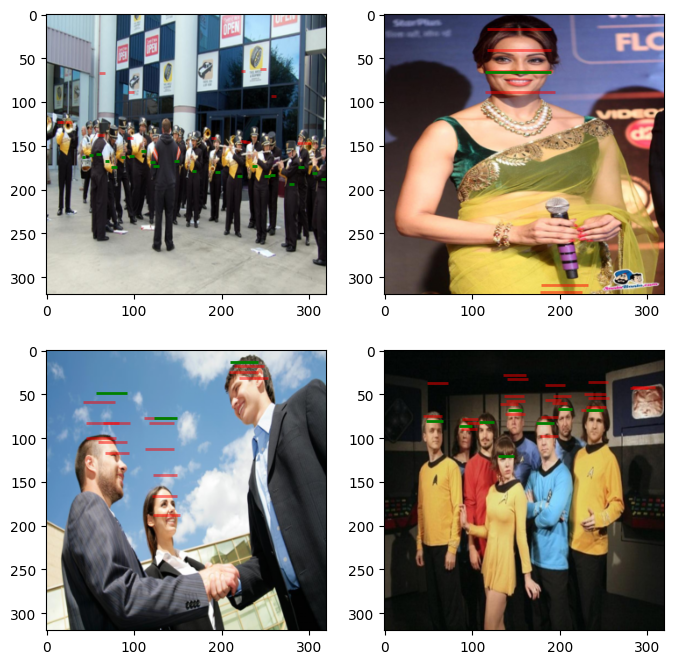

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

data = random.sample(image_boxes, 4)
plot_image_pred_boxes(axs, 0, 0, data[0][0].cpu().numpy().transpose(1, 2, 0), data[0][1].cpu().numpy(), data[0][2].cpu().numpy())
plot_image_pred_boxes(axs, 1, 0, data[1][0].cpu().numpy().transpose(1, 2, 0), data[1][1].cpu().numpy(), data[1][2].cpu().numpy())
plot_image_pred_boxes(axs, 0, 1, data[2][0].cpu().numpy().transpose(1, 2, 0), data[2][1].cpu().numpy(), data[2][2].cpu().numpy())
plot_image_pred_boxes(axs, 1, 1, data[3][0].cpu().numpy().transpose(1, 2, 0), data[3][1].cpu().numpy(), data[3][2].cpu().numpy())

In [59]:
image_boxes[8]

(tensor([[[0.7954, 0.8070, 0.8091,  ..., 0.6140, 0.6247, 0.6274],
          [0.7894, 0.7902, 0.7948,  ..., 0.6302, 0.6188, 0.6205],
          [0.7638, 0.7594, 0.7662,  ..., 0.5985, 0.6019, 0.6133],
          ...,
          [0.4333, 0.4458, 0.4561,  ..., 0.1319, 0.1072, 0.0996],
          [0.4237, 0.4266, 0.4445,  ..., 0.1121, 0.1067, 0.1123],
          [0.4221, 0.4164, 0.4293,  ..., 0.1044, 0.1014, 0.1071]],
 
         [[0.7999, 0.8092, 0.8081,  ..., 0.6219, 0.6325, 0.6352],
          [0.7978, 0.7982, 0.8013,  ..., 0.6380, 0.6267, 0.6284],
          [0.7809, 0.7769, 0.7832,  ..., 0.6069, 0.6103, 0.6216],
          ...,
          [0.2691, 0.2764, 0.2830,  ..., 0.1422, 0.1397, 0.1380],
          [0.2592, 0.2571, 0.2711,  ..., 0.1403, 0.1409, 0.1455],
          [0.2560, 0.2463, 0.2547,  ..., 0.1472, 0.1379, 0.1330]],
 
         [[0.8054, 0.8080, 0.7961,  ..., 0.6179, 0.6286, 0.6313],
          [0.7925, 0.7892, 0.7862,  ..., 0.6341, 0.6227, 0.6244],
          [0.7614, 0.7569, 0.7679,  ...,